In [1]:
from collections import defaultdict
import dask.distributed
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from apriori_general_v2 import apriori_disk, check_itemsets
import numpy as np
import os
import pickle
import datetime
from clustering import visualize_clusters, sph_kmeans
from scipy.sparse import csr_matrix

In [2]:
count_dict = defaultdict(int)

#setup stuff
client = dask.distributed.Client(n_workers=6, threads_per_worker=1)  # Adjust based on your CPU
nltk_stopwords = stopwords.words('english')
with open('additional_stopwords.txt', 'r') as file:
    extra_stopwords = [line.strip() for line in file.readlines()]

extra_stopwords.extend(nltk_stopwords)
extra_stopwords.extend(['links', 'external', 'see', 'may', 'refer', 'link', 'wa'])

porter_stemmer = PorterStemmer()
extra_stopwords_stemmed = [porter_stemmer.stem(word) for word in extra_stopwords]
stopwords_set = set(extra_stopwords_stemmed)

In [3]:
# data = 'data/combined_stemmed.csv'
# block_size = "100MB"

data = 'data/pruned_stemmed.csv'
block_size = "10MB"

# min_supports_list = np.arange(start=0.5, stop=0.15, step=--0.05)

min_supports_list = [0.45]

for min_support in min_supports_list:
    
    print(f"Testing min_support = {min_support}")
    directory = f"data/minsupp_{min_support}"
    if not os.path.exists(directory):
        os.mkdir(directory)

    # run the apriori disk function
    frequent_itemsets, string_mapping = apriori_disk(data_file=data,
                                                     exclude=stopwords_set,
                                                     min_support_percent=min_support,
                                                     blocksize=block_size,
                                                     client=client)

    # if function returns nothing, don't need to continue
    if not frequent_itemsets or not string_mapping:
        continue

    # if you want to recreate the list with the original strings
    with open(f"{directory}/itemsets_and_supports.txt", 'w') as f:
        for freq_itemset, support in frequent_itemsets.items():
            # Suppose you have a set of integers called int_set
            reconstructed_strings = set(key for key, value in string_mapping.items() if value in freq_itemset)
            f.write(f"{reconstructed_strings}: {support}\n")

    # the frequent itemsets are the keys of the frequent_itemsets dictionary
    freq_itemsets_list = list(frequent_itemsets.keys())

    # for clustering purposes, find if each itemset is present in each line
    itemset_features = check_itemsets(data, freq_itemsets_list, string_mapping, block_size, client=client)

    # save all variables so don't need to re-run script + for clustering
    with open(f'{directory}/frequent_itemsets.pkl', 'wb') as f:
        pickle.dump(frequent_itemsets, f)

    with open(f'{directory}/itemset_features.pkl', 'wb') as f:
        pickle.dump(itemset_features, f)

    with open(f'{directory}/itemset_list.pkl', 'wb') as f:
        pickle.dump(freq_itemsets_list, f)

    with open(f'{directory}/string_mapping.pkl', 'wb') as f:
        pickle.dump(string_mapping, f)

    with open(f'{directory}/log.txt', 'w') as f:
        now = datetime.datetime.now()
        f.write("finished at " + now.strftime("%Y-%m-%d %H:%M:%S"))


Testing min_support = 0.45
no rows:  25002
First pass completed
Frequent Itemsets Level 1 completed
54 itemsets found
generating candidates
size of total pairs: 12.4140625KB
scattered sublists
1426 candidates generated
checking frequency of itemsets...
Frequent Itemsets Level 2 completed
168 itemsets found

generating candidates
size of total pairs: 118.5703125KB
scattered sublists
515 candidates generated
checking frequency of itemsets...
Frequent Itemsets Level 3 completed
115 itemsets found

generating candidates
size of total pairs: 51.8203125KB
scattered sublists
55 candidates generated
checking frequency of itemsets...
Frequent Itemsets Level 4 completed
11 itemsets found

generating candidates
size of total pairs: 0.5390625KB
scattered sublists
1 candidates generated
checking frequency of itemsets...
No more frequent itemsets to be found at level 5!


In [8]:
print(itemset_features)

[[ True  True  True ... False False False]
 [False  True  True ... False False False]
 [ True False  True ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [False  True  True ... False False False]
 [False False  True ...  True  True False]]


In [4]:
my_num_clusters = 5

# Perform bisecting k-means
#my_cluster_labels = bisecting_kmeans(my_itemset_features, my_num_clusters)

itemset_matrix = csr_matrix(itemset_features.astype(int))
density = itemset_matrix.getnnz() / np.prod(itemset_matrix.shape)
print("density of matrix:", density)

sphkmeans_cluster_labels = sph_kmeans(itemset_matrix, my_num_clusters)

density of matrix: 0.4927033423533014
initialization_time=0.007580 sec, sparsity=0.441
n_iter=1, changed=17100, inertia=8967.453, iter_time=1.838 sec, sparsity=0.733
n_iter=2, changed=6576, inertia=8054.719, iter_time=1.771 sec, sparsity=0.789
n_iter=3, changed=3776, inertia=7835.558, iter_time=1.784 sec, sparsity=0.793
n_iter=4, changed=2463, inertia=7783.745, iter_time=1.778 sec, sparsity=0.797
n_iter=5, changed=1402, inertia=7749.071, iter_time=1.802 sec, sparsity=0.795
n_iter=6, changed=686, inertia=7738.076, iter_time=1.794 sec, sparsity=0.794
n_iter=7, changed=417, inertia=7741.181, iter_time=1.805 sec, sparsity=0.793
n_iter=8, changed=375, inertia=7742.968, iter_time=1.802 sec, sparsity=0.792
n_iter=9, changed=339, inertia=7742.626, iter_time=1.804 sec, sparsity=0.79
n_iter=10, changed=250, inertia=7740.831, iter_time=1.750 sec, sparsity=0.789


In [5]:
from kmodes.kmodes import KModes
km = KModes(n_clusters=my_num_clusters, init='Huang', n_init=5, verbose=1)
kmodes_cluster_labels = km.fit_predict(itemset_features)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4890, cost: 1472124.0
Run 1, iteration: 2/100, moves: 1874, cost: 1455994.0
Run 1, iteration: 3/100, moves: 988, cost: 1453716.0
Run 1, iteration: 4/100, moves: 359, cost: 1453058.0
Run 1, iteration: 5/100, moves: 277, cost: 1451833.0
Run 1, iteration: 6/100, moves: 490, cost: 1449601.0
Run 1, iteration: 7/100, moves: 381, cost: 1448307.0
Run 1, iteration: 8/100, moves: 146, cost: 1447943.0
Run 1, iteration: 9/100, moves: 147, cost: 1447585.0
Run 1, iteration: 10/100, moves: 118, cost: 1447476.0
Run 1, iteration: 11/100, moves: 75, cost: 1447442.0
Run 1, iteration: 12/100, moves: 0, cost: 1447442.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4331, cost: 1462492.0
Run 2, iteration: 2/100, moves: 1122, cost: 1457532.0
Run 2, iteration: 3/100, moves: 626, cost: 1450188.0
Run 2, iteration: 4/100, moves: 454, cost

For n_clusters = 5 The average silhouette_score is : 0.10706092820172962


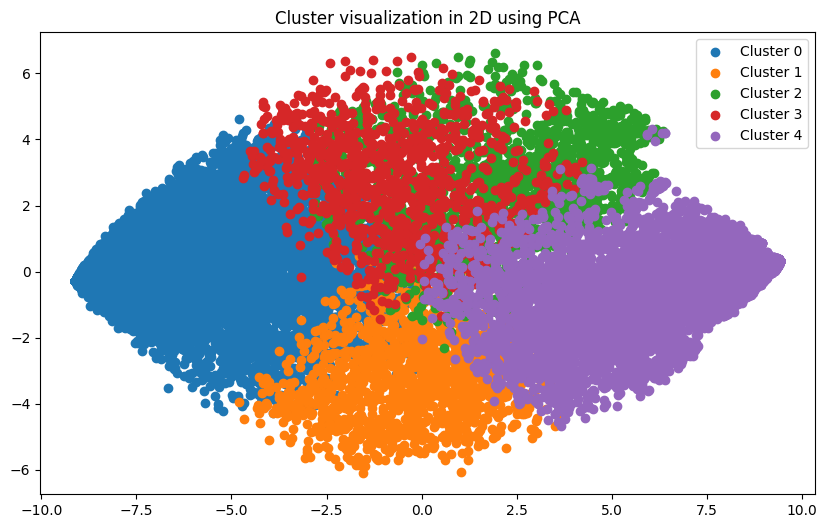

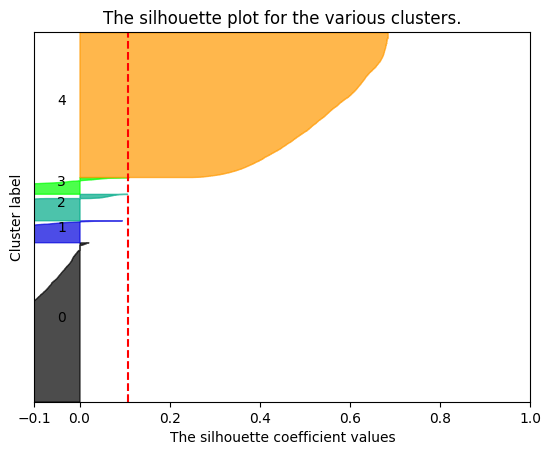

In [6]:
visualize_clusters(kmodes_cluster_labels, itemset_features, metric='cosine')

For n_clusters = 5 The average silhouette_score is : 0.22902654451760357


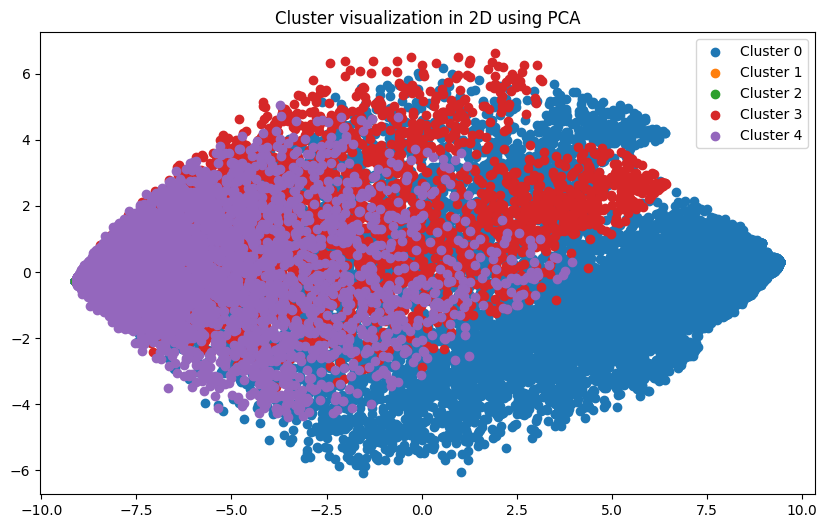

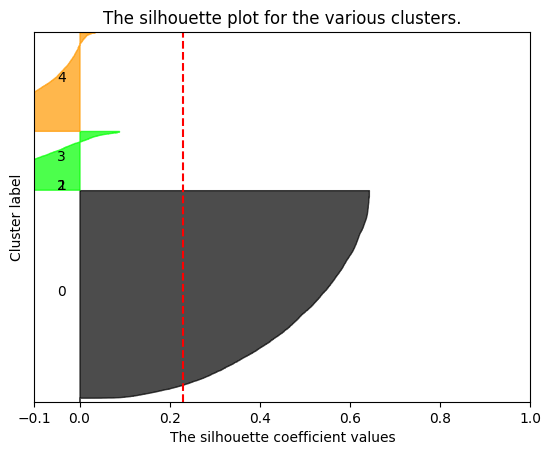

In [7]:
visualize_clusters(sphkmeans_cluster_labels, itemset_features, metric='cosine')

In [5]:
#agglomerative clustering

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

# Compute the cosine similarity matrix
similarity = cosine_similarity(itemset_features)

print(similarity.__sizeof__()/1024)

# # Convert to distance matrix
# distance = 1 - similarity

# # Perform agglomerative clustering
# clustering = AgglomerativeClustering(affinity='precomputed', linkage='complete', n_clusters=n_clusters)
# agglo_cluster_labels = clustering.fit_predict(distance)

4883593.90625


In [ ]:
visualize_clusters(agglo_cluster_labels, itemset_features, metric='cosine')